# Gradient Symbolic Computation

see `TPR_example.ipynb` for details about the TP representation and one possible empirical phenomenon, that can be handled with GSC.

In [1]:
import os
os.chdir("C:\\Users\\Slavist29\\Desktop\\GSG\\experiments\\grascom") # change this if you download the notebook

In [2]:
# Imports
from src.classes.Grammar import Grammar
from src.gsc.gsc_network import Net
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
# Set seed for reproducibility
torch.manual_seed(1111)

## Grammar and Harmonic Constraints

In [3]:
# Fillers and Roles
# Fillers and Roles
fillers = ["bhud", "budh", "bhut", "bud", "bhudi", "budhi", "ta", "dha"]
roles = ["r", "s"]  # root & suffix

# Build Grammar
G = Grammar(fillers, roles, emtpyFiller="#")
#G = Grammar(fillers, roles, emtpyFiller="#", fillerSimilarities=similarities)

Buil Filler Matrix
Representations built after 309 attempts

Build role Matrix
Representations built after 105 attempts



In [4]:
print(f"Roles representation matrix:\n{pd.DataFrame(G.bind.R.numpy(), index=roles, columns=roles)}\n")
print(f"Fillers representation matrix:\n{pd.DataFrame(G.bind.F.numpy(), index=fillers, columns=fillers)}\n")

Roles representation matrix:
          r         s
r -0.805551  0.592526
s  0.592526  0.805551

Fillers representation matrix:
           bhud      budh      bhut       bud     bhudi     budhi        ta  \
bhud  -0.282130 -0.191657 -0.062332  0.795572 -0.237267  0.129793  0.199676   
budh  -0.087131 -0.358127  0.134787 -0.135866  0.677845  0.398404 -0.136842   
bhut  -0.073933  0.360393 -0.271334 -0.372837 -0.206826  0.481812  0.536764   
bud    0.084847 -0.116372 -0.028122 -0.292542 -0.330182 -0.473583 -0.226019   
bhudi  0.177566 -0.448732 -0.442107 -0.088348 -0.390434  0.452120 -0.424702   
budhi -0.215124 -0.612201 -0.300021 -0.210351  0.095698 -0.342673  0.532068   
ta    -0.052492  0.326964 -0.784171  0.168269  0.393178 -0.213933 -0.203430   
dha   -0.905308  0.092359  0.056023 -0.208925 -0.127468  0.019985 -0.312013   

            dha  
bhud   0.365839  
budh   0.436579  
bhut   0.298304  
bud    0.713093  
bhudi -0.163167  
budhi -0.187062  
ta     0.073206  
dha   -0.105354  

## Single Constituents Harmony

The following code sets the harmony values for single bindings. 

There will be *Harmony crosstalk* if the vector representing those bindings are not independent (dot product == 0). Let's suppose that the vector representing "bhud/r" has a non-null dotproduct with the vector representing "budh/r". Then "budh/r" will also improve its harmony by a factor $H_{budh/r} \times (bhud/r \cdot budh/r)$


In [5]:
# Single Harmony constraints (agnostic, but do distinguish between root and suffixes)
cons = [("bhud/r", 1), ("budh/r", 1), ("bud/r", 1), ("bhut/r", 1), 
        ("bhudi/r", 1), ("budhi/r", 1), ("dha/s", 1), ("ta/s", 1),
        ("bhud/s", -10), ("budh/s", -10), ("bud/s", -10), ("bhut/s", -10),
        ("bhudi/s", -10), ("budhi/s", -10), ("dha/r", -10), ("ta/r", -10)]
G.update_Hc(cons)

In [6]:
harmonies = G.Hc.numpy()
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,r,s
bhud,1.0,-10.0
budh,1.0,-10.0
bhut,1.0,-10.0
bud,1.0,-10.0
bhudi,1.0,-10.0
budhi,1.0,-10.0
ta,-10.0,1.0
dha,-10.0,1.0


<AxesSubplot:>

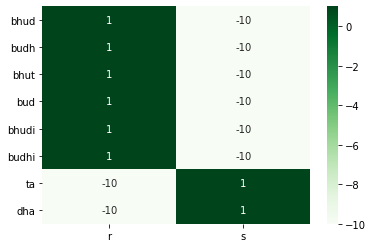

In [7]:
sns.heatmap(harmonies, annot=True, cmap="Greens")

## Pairwise Harmonies:

These constraints provide a way to declare Harmonic Constraints in the GSC. 
Ex.:

`("bhud/r" "dha/s", -3)` for instance means that the co-occurence of "bhud" as root and "dha" as suffix updates the total Harmony by -3 points.

In [8]:
# Pairwise Harmony
# Implements the Harmonic Constraints (see Optimization project written in Julia)
cons = [("bhud/r", "ta/s", -3),  # violates voice contrast
        ("budh/r", "ta/s", -3),  # violates voice contrast and License(laryngeal)
        ("bhud/r", "dha/s", -1),  # lazyness
        ("budh/r", "dha/s", -4),  # License & Lazyness
        ("bhut/r", "dha/s", -4),  # Lazyness and voice contrast
        ("bud/r", "dha/s", -1),  # Ident(lar)
        ("bud/r", "ta/s", - 4),  # voice contrast & Ident(lar)
        ("bhud/r", "ta/s", -10.5),
        ("bhudi/r", "ta/s", - 3),  # DepIO
        ("budhi/r", "ta/s", - 3),  # DepIO
        ("bhudi/r", "ta/s", - 5),  # DepIO & Ident(lar)
        ("budhi/r", "ta/s", - 5),  # DepIO & Ident(lar)
        ("bud/r", "dha/s", 10),  # Give the optimal candidate more harmony
        ]
G.update_Hcc(cons)

## GSC Net

In [9]:
# Custom settings (these substitute the hard-coded settings)

# ---------------------------------------
#           GSC NET
# ---------------------------------------
custom_settings = {"epochs": 3,
                   "tgtStd": 0.00125,
                   "emaFactor": 0.001,
                   "emaSpeedTol": .00051,
                   "dt": 1e-3,
                   "TDecayRate": 0.02,
                   "TInit": 8e-3,
                   "lambdaDecayRate": 0.75,
                   "lambdaMin": 0.01,
                   "maxSteps": 20000,
                   "printInterval": 10000,
                   'bowl_center': 0.4,
                   'beta_min_offset': .01,
                   'q_init': 4.5,
                   'clamp': False}
# Initialize
N = Net(G, custom_settings=custom_settings, extData_path="data/inp_pandas.csv")


Input processed: bhud-budh-bhut-dha-ta

Value for Q set to 27.510007661671946
LAMBDA RECOMMENDED: 0.006014718884127685, ACTUAL LAMBDA = 0.011387


If you want to change to the recommended Lambda value press 'y', else any other key: 


T RECOMMENDED: 2.1414550579050893e-05, ACTUAL T = 0.008


If you want to change to the recommended value press 'y', else any other key: 


The external data were provided in form of a simple csv file and were imported in the GSCNet using `pandas`:

In [10]:
# EXTERNAL INPUTS 

# Read dataframe
inputs = pd.read_csv("data/inp_pandas.csv", sep=",")

inputNames = []
nStimuli = len(inputs['id'].unique())

# Initialize stimuli tensor
stimuli = torch.zeros((nStimuli, len(fillers) + 1, len(roles)))

# Loop over the single inputs as whole
for idx, i in enumerate(inputs['id'].unique()):
    inp_string = ""
    stimulus = inputs[inputs.id == i].to_numpy()[:, 1:]

    # Loop over the fillers in a given input
    for filler in stimulus:
        fidx = N.filler2index[filler[0]]
        inp_string += filler[0] + "-"
        for roledix in range(N.grammar.bind.nR):
            stimuli[idx, fidx, roledix] = filler[roledix+1]
    print(f"Input processed: {inp_string[:-1]}\n")
    # Store the names for later plotting
    inputNames.append(inp_string[:-1])

Input processed: bhud-budh-bhut-dha-ta



         r    s
bhud   0.7  0.0
budh   0.9  0.0
bhut   0.2  0.0
bud    0.0  0.0
bhudi  0.0  0.0
budhi  0.0  0.0
ta     0.0  0.6
dha    0.0  0.4


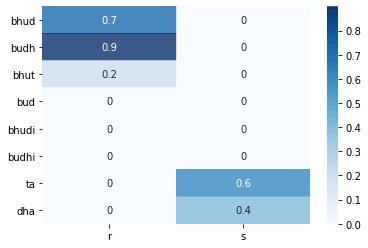

In [11]:
stim = N.stimuli[0,:,:].numpy()
stim = pd.DataFrame(stim, columns=roles, index=fillers)
print(stim)
sns.heatmap(stim, alpha=.8, cmap="Blues", annot=True)
plt.show()

This input represents a gradient blend of three possible root allomorphs (bhud, budh, bhut) and two allomorphs for the suffixes (ta, dha)

## Training (Optimization + Quantization)

In [12]:
# Run
p = N()

Stimulus routine::   0%|          | 0/1 [00:00<?, ?it/s]

Value for Q set to 27.510007661671946

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.011387	 Harmony: 5.034964084625244

epoch : 1
stimNum : 1

Conceptual Matrix:
              r         s
bhud   0.443636  0.036496
budh   0.388505  0.036496
bhut   0.362450  0.036497
bud    0.640089  0.036496
bhudi  0.437366  0.036496
budhi  0.437366  0.036496
ta     0.036496 -0.005586
dha    0.036496  0.558250
Nearest TP: bud-dha --- Input : bhud-budh-bhut-dha-ta
Distance between prediction and nearest TP: 1.0941031518623163

--------------------------------------------------------------------------------

STEP : 10000	 Lambda : 0.010000001324581259	 Harmony: -14809.8115234375

epoch : 1
stimNum : 1

Conceptual Matrix:
              r          s
bhud   6.759300  -8.850048
budh   3.344269  -5.890861
bhut   6.054865 -11.724826
bud    7.647375  -1.999861
bhudi  2.014111  -0.701029
budhi -0.716511   2.513558
ta     0.230831  -1.472356
dha   -9.068503


Stimulus routine::   0%|          | 0/1 [00:00<?, ?it/s]


Last best Harmony: -15291.251020100335

Value for Q set to 27.510007661671946

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.011387	 Harmony: 4.9572248458862305

epoch : 2
stimNum : 1

Conceptual Matrix:
              r         s
bhud   0.443636  0.036496
budh   0.388505  0.036496
bhut   0.362450  0.036497
bud    0.640089  0.036496
bhudi  0.437366  0.036496
budhi  0.437366  0.036496
ta     0.036496 -0.005586
dha    0.036496  0.558250
Nearest TP: bud-dha --- Input : bhud-budh-bhut-dha-ta
Distance between prediction and nearest TP: 1.0941031518623163

--------------------------------------------------------------------------------

STEP : 10000	 Lambda : 0.010000001324581259	 Harmony: -14555.240234375

epoch : 2
stimNum : 1

Conceptual Matrix:
              r          s
bhud   6.494505  -8.873250
budh   3.262887  -5.913943
bhut   5.898920 -11.713944
bud    7.423203  -2.038804
bhudi  1.924082  -0.720697
budhi -0.781636   2.507903
t


Stimulus routine::   0%|          | 0/1 [00:00<?, ?it/s]


Last best Harmony: -15652.051002711107

Value for Q set to 27.510007661671946

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.011387	 Harmony: 4.98030948638916

epoch : 3
stimNum : 1

Conceptual Matrix:
              r         s
bhud   0.443636  0.036496
budh   0.388505  0.036496
bhut   0.362450  0.036497
bud    0.640089  0.036496
bhudi  0.437366  0.036496
budhi  0.437366  0.036496
ta     0.036496 -0.005586
dha    0.036496  0.558250
Nearest TP: bud-dha --- Input : bhud-budh-bhut-dha-ta
Distance between prediction and nearest TP: 1.0941031518623163

--------------------------------------------------------------------------------

STEP : 10000	 Lambda : 0.010000001324581259	 Harmony: -15056.291015625

epoch : 3
stimNum : 1

Conceptual Matrix:
              r          s
bhud   6.807880  -8.920370
budh   3.418166  -5.917818
bhut   6.044128 -11.729411
bud    7.782890  -2.020061
bhudi  2.093237  -0.687231
budhi -0.786155   2.479731
ta 


Epoch routine:: 100%|██████████| 3/3 [00:35<00:00, 11.84s/it]


Last best Harmony: -15128.407150851144



# Visualization

In [13]:
from src.gsc.plotting import Plot

In [14]:
fp = "data/full_traces.pt"
nr = len(roles)
nf = len(fillers) +1 
statesDict = G.bind.states
inputNames = N.inputNames


p = Plot(fp_traces="data/full_traces.pt", nf=nf,nr=nr, inputNames=inputNames, statesDict=statesDict)

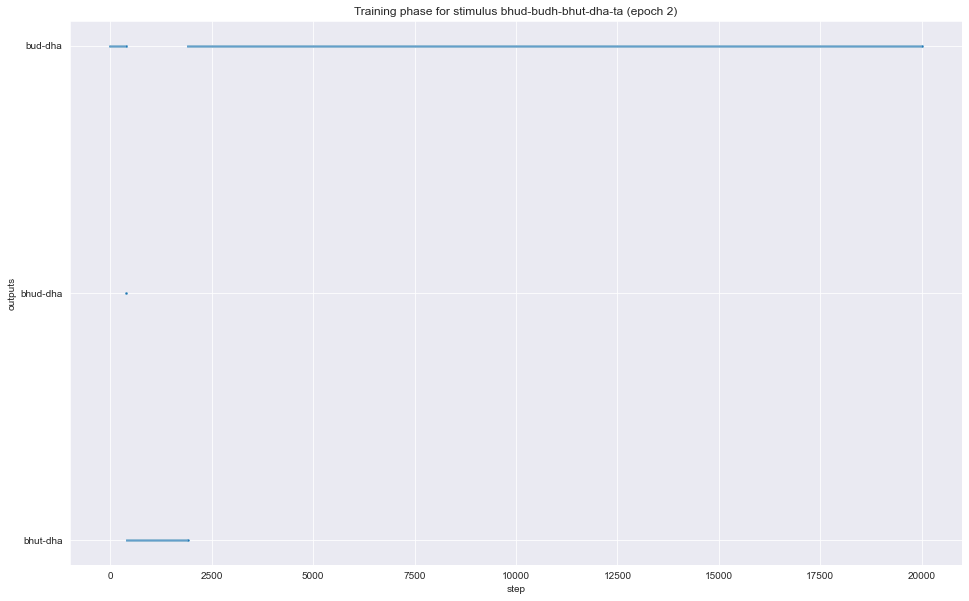

In [15]:

plt.figure(figsize=(16,10))
df = p.plot_epoch(0, 2)

### Harmonies and Frequencies

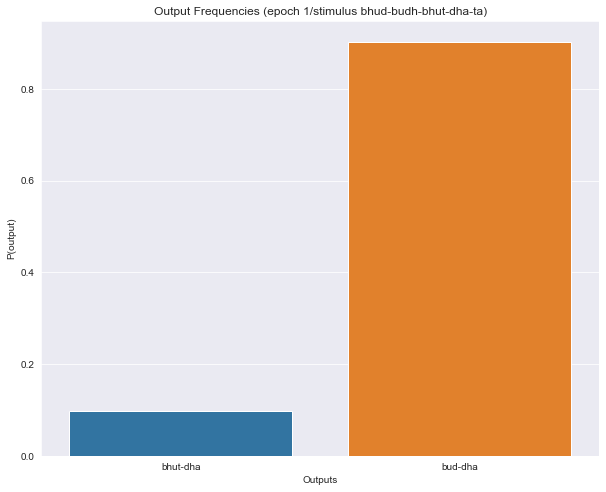

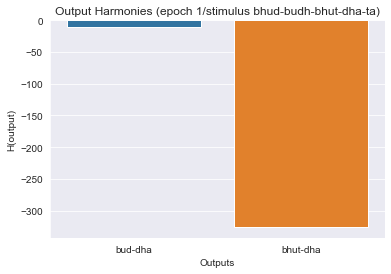

In [16]:
plt.figure(figsize=(10,8))
df = p.plot_final_states(save=True)

### Harmony vs. Activation

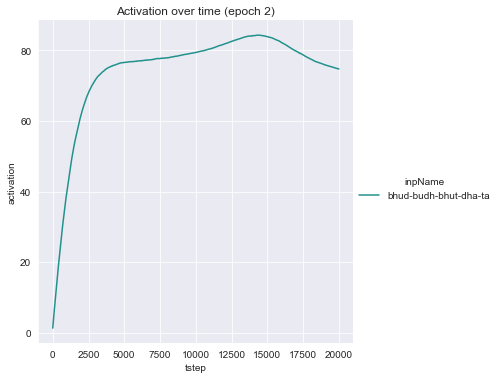

In [17]:
df = p.plot_input_tstep(2,what="activation")

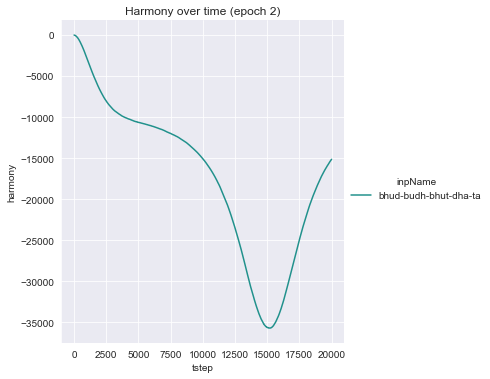

In [18]:
df = p.plot_input_tstep(2,what="harmony")
# Why???

## States update through time

In [19]:
data = p.data
c = data['C_trace']

In [20]:
# Input 0, epoch 2
mat = c[0, 2, i, :, :]
print(mat)
winner = ""
for i in range(mat.shape[1]):
    m = torch.argmax(mat[:,i])
    winner += fillers[m]
print(winner)

tensor([[ 0.4452,  0.0309],
        [ 0.3892,  0.0323],
        [ 0.3646,  0.0284],
        [ 0.6411,  0.0344],
        [ 0.4360,  0.0367],
        [ 0.4371,  0.0376],
        [ 0.0365, -0.0050],
        [ 0.0357,  0.5644]])
buddha


step: 0 for input bhud-budh-bhut-dha-ta 
Winner: buddha


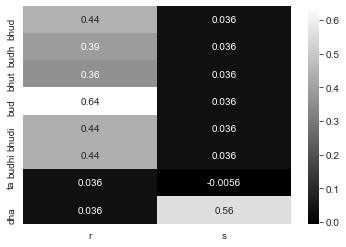

step: 2500 for input bhud-budh-bhut-dha-ta 
Winner: buddha


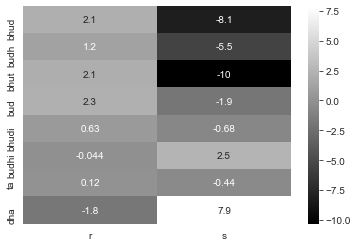

step: 5000 for input bhud-budh-bhut-dha-ta 
Winner: buddha


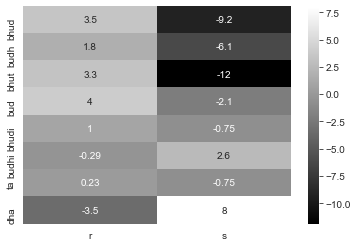

step: 7500 for input bhud-budh-bhut-dha-ta 
Winner: buddha


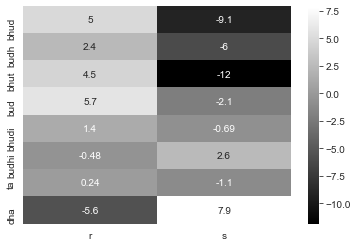

In [21]:
for i in range(0, 10000,2500):
    mat = c[0, 2, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    winner = ""
    for i in range(mat.shape[1]):
        m = torch.argmax(mat[:,i])
        winner += fillers[m]
    print(f"Winner: {winner}")
    sns.heatmap(df, annot=True, cmap="gray")
    plt.show()